### 0. Importación de librerías 

En las siguientes líneas de código se importan las librerías y herramientas necesarias para desarrollar el caso de uso.

In [1]:
!pip install nltk
!pip install cuml

  ERROR: Command errored out with exit status 1:
   command: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-h4m4kz1q/cuml/setup.py'"'"'; __file__='"'"'/tmp/pip-install-h4m4kz1q/cuml/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /tmp/pip-wheel-jxz859lj
       cwd: /tmp/pip-install-h4m4kz1q/cuml/
  Complete output (25 lines):
  running bdist_wheel
  running build
  installing to build/bdist.linux-x86_64/wheel
  running install
  Traceback (most recent call last):
    File "<string>", line 1, in <module>
    File "/tmp/pip-install-h4m4kz1q/cuml/setup.py", line 18, in <module>
      setup(name=pkg,
    File "/usr/lib/python3/dist-packages/setuptools/__init__.py", line 144, in setup
      return distutils.core.setup(**attrs)
    File "/usr/lib/python3.8/distutils/core.py", line 148, in setup
      dist.

In [1]:
# Librerías para manejo de datos
import pandas as pd
pd.set_option('display.max_columns', 25) # Número máximo de columnas a mostrar
pd.set_option('display.max_rows', 50) # Numero máximo de filas a mostar
import numpy as np
np.random.seed(3301)
import pandas as pd
# Para preparar los datos
from sklearn.preprocessing import LabelEncoder

# Para realizar la separación del conjunto de aprendizaje en entrenamiento y test.
from sklearn.model_selection import train_test_split
# Para evaluar el modelo
#Librerías para la visualización
import matplotlib.pyplot as plt
# Seaborn
import seaborn as sns   
from matplotlib import pyplot as plt

from IPython.display import SVG
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import sklearn.model_selection
import sklearn.preprocessing as preproc
from sklearn.feature_extraction import text
import pickle
import warnings
warnings.filterwarnings("ignore")

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/ale/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ale/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Carga de los datos
A través de la librería **pandas** podemos realizar la carga de datos desde diferentes fuentes de información, en este caso se realizará la carga de un archivo plano csv, el separador del archivo es ; y se remplazaron los valores "-" por valores nulos.

## Dataset tweets

In [3]:
# Se cargan los datos. 
df_tweets=pd.read_csv('./archive/mbsa.csv', sep=',', encoding = 'utf-8', header=0)

In [4]:
# Cantidad de datos y número de variables
df_tweets.shape

(19344048, 3)

In [5]:
# Mostrar los datos
df_tweets.head()

,Date,text,Sentiment
0,2019-05-27,È appena uscito un nuovo video! LES CRYPTOMONN...,Positive
1,2019-05-27,Cardano: Digitize Currencies; EOS https://t.co...,Positive
2,2019-05-27,Another Test tweet that wasn't caught in the s...,Positive
3,2019-05-27,Current Crypto Prices! \n\nBTC: $8721.99 USD\n...,Positive
4,2019-05-27,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...,Positive


In [6]:
# Podemos ver los tipos de todas la variables.
df_tweets.dtypes

Date         object
text         object
Sentiment    object
dtype: object

In [7]:
df_tweets["Sentiment"].value_counts()

Negative    9729297
Positive    8723207
Neutral         400
Name: Sentiment, dtype: int64

## Dataset Precios Bitcoin
dado que hay muy pocas muestras nuetrales, decidimos usar el dataset de precios de bitcoin para poder definir cuando hay un cambio positivo, cuando negativo y cuando neutral

In [8]:
# Se cargan los datos. 
df_precios=pd.read_csv('./archive2/coin_Bitcoin.csv', sep=',', encoding = 'utf-8', header=0)

In [9]:
# Cantidad de datos y número de variables
df_precios.shape

(2991, 10)

In [10]:
# Mostrar los datos
df_precios.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


In [11]:
# Podemos ver los tipos de todas la variables.
df_precios.dtypes

SNo            int64
Name          object
Symbol        object
Date          object
High         float64
Low          float64
Open         float64
Close        float64
Volume       float64
Marketcap    float64
dtype: object

# Limpieza y preparación de los datos

Primero vamos a ejecutar los pasos de limpieza de los datos, relacionados el tratamiento de ausencias y registros duplicados.

## Tweets

In [12]:
# Es recomendable que todos los pasos de limpieza y preparación se realicen sobre otro archivo.
df_tweets_l = df_tweets

In [13]:
# Se observa que hay ausencias, sin embargo no son una cantidad significativa:
df_tweets_l.isnull().sum()

Date              0
text             16
Sentiment    891144
dtype: int64

In [14]:
# Eliminación registros con ausencias
df_tweets_l = df_tweets_l.dropna()
# Eliminación de registros duplicados.
df_tweets_l = df_tweets_l.drop_duplicates()

In [15]:
# Cantidad de datos y número de variables
df_tweets_l.shape

(15803216, 3)

In [16]:
df_tweets_l["Sentiment"].value_counts()

Negative    8013795
Positive    7789126
Neutral         295
Name: Sentiment, dtype: int64

In [17]:
df_tweets_l["Date"]=pd.to_datetime(df_tweets_l["Date"], format='%Y-%m-%d', errors='coerce')

In [18]:
df_tweets_l["Date"].describe()

count                15803216
unique                   1893
top       2019-07-26 00:00:00
freq                   174149
first     2014-09-18 00:00:00
last      2019-11-23 00:00:00
Name: Date, dtype: object

## Precios

In [19]:
# Es recomendable que todos los pasos de limpieza y preparación se realicen sobre otro archivo.
df_precios_l = df_precios

In [20]:
# Se observa que hay ausencias, sin embargo no son una cantidad significativa:
df_precios_l.isnull().sum()

SNo          0
Name         0
Symbol       0
Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Marketcap    0
dtype: int64

In [21]:
df_precios_l["Date"]=pd.to_datetime(df_precios_l["Date"], format='%Y-%m-%d', errors='coerce').dt.date
df_precios_l["Date"]=pd.to_datetime(df_precios_l["Date"], format='%Y-%m-%d', errors='coerce')

In [22]:
df_precios_l["Date"].describe()

count                    2991
unique                   2991
top       2013-04-29 00:00:00
freq                        1
first     2013-04-29 00:00:00
last      2021-07-06 00:00:00
Name: Date, dtype: object

In [23]:
df_precios_l["Variacion"]= df_precios_l["Close"]-df_precios_l["Open"]

In [24]:
df_precios_l.drop(["SNo", "Name", "Symbol", "High", "Low", "Open", "Close", "Volume", "Marketcap"], axis=1,inplace=True)

In [25]:
df_precios_l.dtypes

Date         datetime64[ns]
Variacion           float64
dtype: object

## Union de datasets

In [26]:
df_datos=df_tweets_l.merge(df_precios_l, left_on='Date', right_on='Date', how="left")

In [27]:
df_datos.head()

,Date,text,Sentiment,Variacion
0,2019-05-27,È appena uscito un nuovo video! LES CRYPTOMONN...,Positive,131.705973
1,2019-05-27,Cardano: Digitize Currencies; EOS https://t.co...,Positive,131.705973
2,2019-05-27,Another Test tweet that wasn't caught in the s...,Positive,131.705973
3,2019-05-27,Current Crypto Prices! \n\nBTC: $8721.99 USD\n...,Positive,131.705973
4,2019-05-27,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...,Positive,131.705973


In [28]:
df_datos.describe()

,Variacion
count,1.580322e+07
mean,2.291744e+00
std,4.522762e+02
min,-2.345600e+03
25%,-1.763449e+02
50%,9.329834e-01
75%,1.896414e+02
max,3.633600e+03


In [29]:
percentile_positive=df_datos["Variacion"].quantile(0.66)
percentile_negative=df_datos["Variacion"].quantile(0.33)

In [30]:
df_datos.loc[df_datos["Variacion"]>percentile_positive, "Influencia"]= 1
df_datos.loc[df_datos["Variacion"]<percentile_negative, "Influencia"]= -1
df_datos.loc[(df_datos["Variacion"]>=percentile_negative) & (df_datos["Variacion"]<=percentile_positive), "Influencia"]= 0

In [31]:
df_datos["Influencia"].value_counts()

 1.0    5312443
 0.0    5284584
-1.0    5206189
Name: Influencia, dtype: int64

In [32]:
df_datos.drop( ["Date","Sentiment", "Variacion"],axis=1,inplace=True)

In [33]:
df_datos.head()

,text,Influencia
0,È appena uscito un nuovo video! LES CRYPTOMONN...,1.0
1,Cardano: Digitize Currencies; EOS https://t.co...,1.0
2,Another Test tweet that wasn't caught in the s...,1.0
3,Current Crypto Prices! \n\nBTC: $8721.99 USD\n...,1.0
4,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...,1.0


In [34]:
df_datos["text"]=df_datos['text'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

## Limpieza

In [35]:
df_datos=df_datos.loc[1:1000000]

In [36]:
df_datos.shape

(1000000, 2)

In [37]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [38]:
def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    # remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    # Tokenize each word
    text =  nltk.WordPunctTokenizer().tokenize(text)
        
    return text

In [39]:
df_datos['text'] = list(map(clean_text, df_datos.text))

In [40]:

def lemmatized_words(text):
    lemm = nltk.stem.WordNetLemmatizer()
    df_datos['lemmatized'] = list(map(lambda word:
                                     list(map(lemm.lemmatize, word)),
                                     df_datos.text))
    

lemmatized_words(df_datos.text)

In [41]:
df_datos.head(3)


,text,Influencia,lemmatized
1,"[cardano, digitize, currencies, eos]",1.0,"[cardano, digitize, currency, eos]"
2,"[another, test, tweet, caught, stream, bitcoin]",1.0,"[another, test, tweet, caught, stream, bitcoin]"
3,"[current, crypto, prices, btc, 8721, 99, usd, ...",1.0,"[current, crypto, price, btc, 8721, 99, usd, e..."


In [42]:
pd.set_option('max_colwidth', 500)
df_datos[['Influencia', 'text', 'lemmatized']].sample(3)

,Influencia,text,lemmatized
808235,1.0,"[capitalism, feeding, bitcoin, natural, selection, cute, age, vulnerable, child, discovered, cute, lost, baby, bear, took, home, named, btc, cute, kitten, lion, lap, capitalism, natural, selection, work, see, kitten, see, future, king, economy]","[capitalism, feeding, bitcoin, natural, selection, cute, age, vulnerable, child, discovered, cute, lost, baby, bear, took, home, named, btc, cute, kitten, lion, lap, capitalism, natural, selection, work, see, kitten, see, future, king, economy]"
336089,1.0,"[really, simple, folks, bitcoin, buy, watch, bnb, increase, bnb, buy, watch, bitcoin, increase, like, instance, thankmelater]","[really, simple, folk, bitcoin, buy, watch, bnb, increase, bnb, buy, watch, bitcoin, increase, like, instance, thankmelater]"
741410,-1.0,"[indian, bitcoin, trader, commits, suicide, losses, trading, crypto, local, officials, newsbtc, crypto, india]","[indian, bitcoin, trader, commits, suicide, loss, trading, crypto, local, official, newsbtc, crypto, india]"


In [43]:
bow_converter = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)
x = bow_converter.fit_transform(df_datos['text'])

words = bow_converter.get_feature_names()
len(words)

394027

In [44]:
bigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[2,2], lowercase=False) 
x2 = bigram_converter.fit_transform(df_datos['text'])
bigrams = bigram_converter.get_feature_names()
len(bigrams)

3161266

In [45]:
bigrams[-10:]

['~~~ xrp',
 '~~~ ~',
 '~~~ ~~',
 '~~~> 0',
 '~~~~ btc',
 '~~~~ gt',
 '~~~~ lol',
 '~~~~~ gt',
 '~~~~~ the',
 '~~~~~~~~~~ btc']

In [46]:
trigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[3,3], lowercase=False) 
x3 = trigram_converter.fit_transform(df_datos['text'])
trigrams = trigram_converter.get_feature_names()
len(trigrams)

5349843

In [47]:
trigrams[:10]


['0 0 0',
 '0 0 000',
 '0 0 00000000',
 '0 0 00000060',
 '0 0 00000114',
 '0 0 00000128',
 '0 0 0001692413685',
 '0 0 0003',
 '0 0 00161727',
 '0 0 01']

In [48]:
print(len(words), len(bigrams), len(trigrams))


394027 3161266 5349843


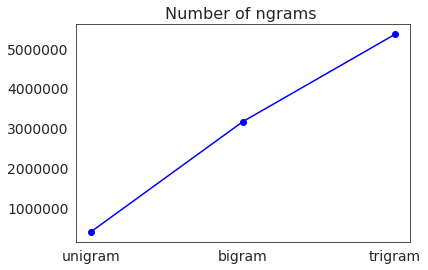

In [49]:
sns.set_style("white")
counts = [len(words), len(bigrams), len(trigrams)]
plt.plot(counts, color='blue')
plt.plot(counts, 'bo')
#plt.margins(0.1)
plt.ticklabel_format(style = 'plain')
plt.xticks(range(3), ['unigram', 'bigram', 'trigram'])
plt.tick_params(labelsize=14)
plt.title('Number of ngrams ', {'fontsize':16})
plt.show()

# Modelo

In [50]:
training_data, test_data = sklearn.model_selection.train_test_split(df_datos, train_size = 0.7, random_state=42)

In [51]:
print(training_data.shape)
print(test_data.shape)

(700000, 3)
(300000, 3)


In [52]:
bow_transform = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[3,3], lowercase=False)

In [53]:
X_tr_bow = bow_transform.fit_transform(training_data['text'])

In [54]:
len(bow_transform.vocabulary_)

3954258

In [55]:
X_tr_bow.shape

(700000, 3954258)

In [56]:
X_te_bow = bow_transform.transform(test_data['text'])

In [61]:
y_tr = training_data['Influencia']
y_te = test_data['Influencia']

In [57]:
tfidf_transform = text.TfidfTransformer(norm=None)
X_tr_tfidf = tfidf_transform.fit_transform(X_tr_bow)

In [58]:
X_te_tfidf = tfidf_transform.transform(X_te_bow)


In [59]:
def simple_logistic_classify(X_tr, y_tr, X_test, y_test, description, _C=1.0):
    model = LogisticRegression(C=_C).fit(X_tr, y_tr)
    score = model.score(X_test, y_test)
    print('Test Score with', description, 'features', score)
    return model

In [62]:
model_bow = simple_logistic_classify(X_tr_bow, y_tr, X_te_bow, y_te, 'bow')
model_tfidf = simple_logistic_classify(X_tr_tfidf, y_tr, X_te_tfidf, y_te, 'tf-idf')

Test Score with bow features 0.6528533333333333
Test Score with tf-idf features 0.65371


In [63]:
param_grid_ = {'C': [1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e2]}
bow_search = sklearn.model_selection.GridSearchCV(LogisticRegression(), cv=5, param_grid=param_grid_)
tfidf_search = sklearn.model_selection.GridSearchCV(LogisticRegression(), cv=5,
                                   param_grid=param_grid_)

In [64]:
bow_search.fit(X_tr_bow, y_tr)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [1e-05, 0.001, 0.1, 1.0, 10.0, 100.0]})

In [65]:
bow_search.best_score_

0.6518685714285714

In [ ]:
tfidf_search.fit(X_tr_tfidf, y_tr)

In [ ]:
tfidf_search.best_score_


In [ ]:
bow_search.best_params_


In [ ]:
tfidf_search.best_params_


In [ ]:
bow_search.cv_results_